## <span style='color:Blue'> Web Scrapping NSE website using BeautifulSoup

The objective is to do a trending analysis of NSE Advance Decline Ratio. A sample image of what we are trying to read from NSE.

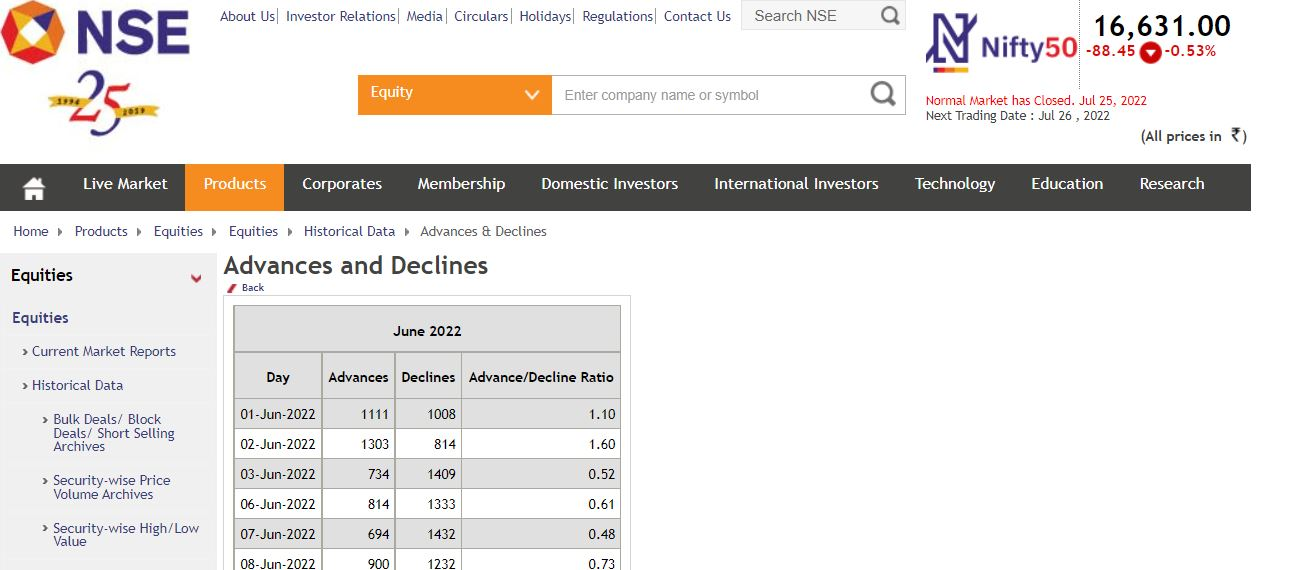




As a start upgrade pandas package to 1.4.3

In [1]:
#pip install pandas == 1.4.3


I always like ignoring warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

The user has to provide:
1. start_date
2. end_date

Based on start and end date we are going to use pandas package pd.date_range to create a date_list variable. The date_list variable will be used to create dynamic links in the for loop below

In [3]:
import datetime
import pandas as pd

start_date = datetime.datetime(2012,1,1)
end_date = datetime.datetime(2022,6,30)

date_list = pd.date_range(start_date,end_date,freq = 'M',inclusive="both").strftime("%b%Y")
date_list = date_list.str.lower()

1. Create an empty dataframe df
2. Create dynamic url using the date_list variable.
3. Use beautiful soup to parse through the HTML
4. Create 4 variable date,adv,dec,adv_dec_ratio
5. Append the ouput to empty dataframe df

In [4]:
import requests
import json
from requests.auth import HTTPBasicAuth


from bs4 import BeautifulSoup

df = pd.DataFrame()

for i in date_list:
    url = 'https://www1.nseindia.com/products/content/equities/equities/eq_advdec'+ i + '.htm'
    headers = {'User-Agent': 'Mozilla/5.0'}
    page = requests.get(url,headers=headers,auth=HTTPBasicAuth('user', 'pass'))
    soup = BeautifulSoup(page.text, 'html.parser')
    
    table = soup.find('table')
    rows = table.find_all('tr')
    
    for row in rows:
        try:
            date = row.find('td',attrs = {'class':'date'}).get_text()
            adv = int(row.find_all('td',attrs = {'class':'number'})[0].get_text())
            dec = int(row.find_all('td',attrs = {'class':'number'})[1].get_text())
            adv_dec_ratio = float(row.find_all('td',attrs = {'class':'number'})[2].get_text())
            output = pd.DataFrame([[date,adv,dec,adv_dec_ratio]],columns=['Date','Adv','Dec','Adv_Dec_Ratio'])
            df = df.append(output)
        except:
            pass



In [5]:
df.head(n=2)

,Date,Adv,Dec,Adv_Dec_Ratio
0,02-Jan-2012,767,678,1.13
0,03-Jan-2012,1237,237,5.22


1. Converting the date variable from format string to date
2. I recalculate the advance decline ratio as the figures from NSE for 2014 are incorrect


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Adv_Dec_Ratio_Recalc'] = df['Adv']/df['Dec']

In [7]:
df[df['Date']>= '2014-01-01'].head(20)


,Date,Adv,Dec,Adv_Dec_Ratio,Adv_Dec_Ratio_Recalc
0,2014-01-01,957,413,86.0,2.317191
0,2014-01-02,422,980,66.0,0.430612
0,2014-01-03,705,640,85.0,1.101562
0,2014-01-06,796,565,92.0,1.408850
0,2014-01-07,626,738,105.0,0.848238
0,2014-01-08,771,609,96.0,1.266010
0,2014-01-09,483,920,72.0,0.525000
0,2014-01-10,446,939,89.0,0.474973
0,2014-01-13,705,746,86.0,0.945040
0,2014-01-14,606,830,86.0,0.730120


Plot a simple line chart of the Adv_Ratio variable. There is a lot of noise and does not provide valuable information

<AxesSubplot:xlabel='Date'>

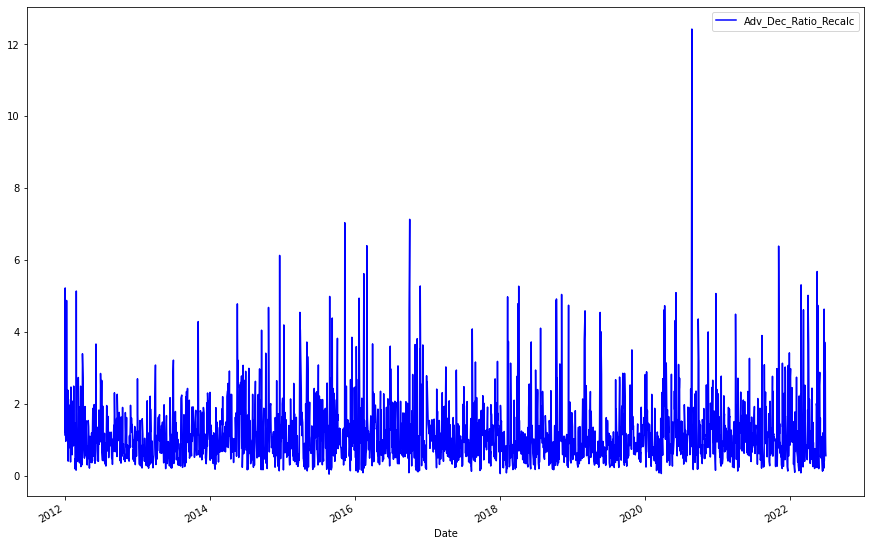

In [8]:
df.plot(x = 'Date' , y = 'Adv_Dec_Ratio_Recalc' , figsize = (15,10) , color = 'blue')

To smoothen the series I use a 60 (approx 3 months) day moving average of the series.

In [9]:
import numpy as np
df['Mean_Adv_Dec_Ratio'] = df['Adv_Dec_Ratio_Recalc'].rolling(100,1).mean()

In [10]:
df.head(n= 20)

,Date,Adv,Dec,Adv_Dec_Ratio,Adv_Dec_Ratio_Recalc,Mean_Adv_Dec_Ratio
0,2012-01-02,767,678,1.13,1.131268,1.131268
0,2012-01-03,1237,237,5.22,5.219409,3.175339
0,2012-01-04,791,655,1.21,1.207634,2.519437
0,2012-01-05,797,661,1.21,1.205749,2.191015
0,2012-01-06,707,738,0.96,0.957995,1.944411
0,2012-01-07,930,380,2.45,2.447368,2.028237
0,2012-01-09,950,531,1.79,1.789077,1.994071
0,2012-01-10,1252,257,4.87,4.871595,2.353762
0,2012-01-11,1030,471,2.19,2.186837,2.335215
0,2012-01-12,740,742,1.00,0.997305,2.201424


<AxesSubplot:xlabel='Date'>

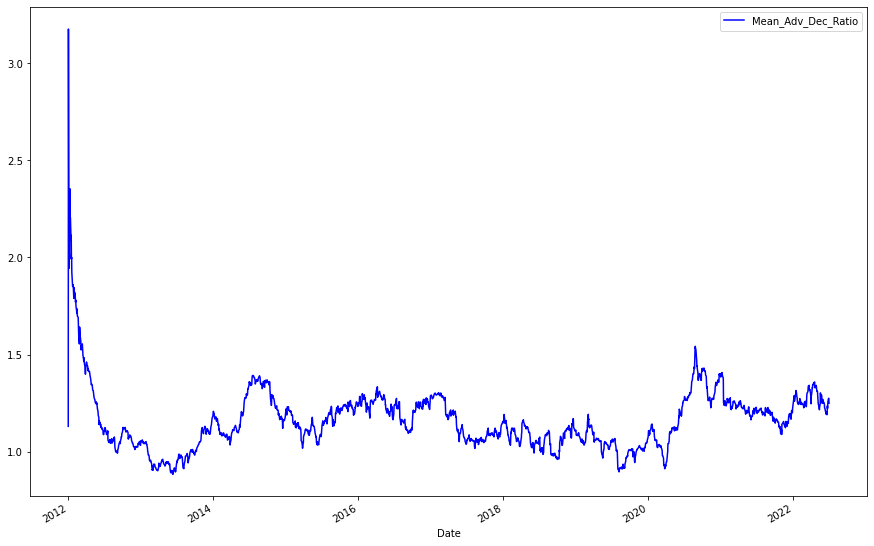

In [11]:
df.plot(x = 'Date' , y = 'Mean_Adv_Dec_Ratio' , figsize = (15,10) , color = 'blue')

One other way to visualize the time series will be through a heatmap.
Hence i proceed creating a matrix x indexed by month with column being indexed by year. 


In [12]:
x = pd.pivot_table(df,values = 'Mean_Adv_Dec_Ratio',index = df['Date'].dt.strftime('%m') , columns = df['Date'].dt.strftime('%Y'))

In [13]:
x.head(n=5)

Date,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Date,,,,,,,,,,,
01,2.056421,1.049243,1.166243,1.212148,1.260872,1.289636,1.131366,1.079756,1.111601,1.314898,1.275210
02,1.717389,0.966348,1.090110,1.149054,1.235567,1.295059,1.096025,1.065039,1.045463,1.252089,1.249687
03,1.500060,0.917949,1.071321,1.095137,1.260783,1.224627,1.057629,1.130615,0.969970,1.243299,1.293305
04,1.402938,0.939702,1.109410,1.103177,1.299356,1.199574,1.133215,1.065515,1.064048,1.237876,1.331953
05,1.268066,0.934419,1.150891,1.129955,1.246753,1.125542,1.070703,1.024008,1.119829,1.202697,1.261636


Here is my heatmap. The whitespaces in the map are basically holidays or non trading days

Text(0.5, 1.0, 'Advance Decline Ratio HeatMap Rolling 100d Averge')

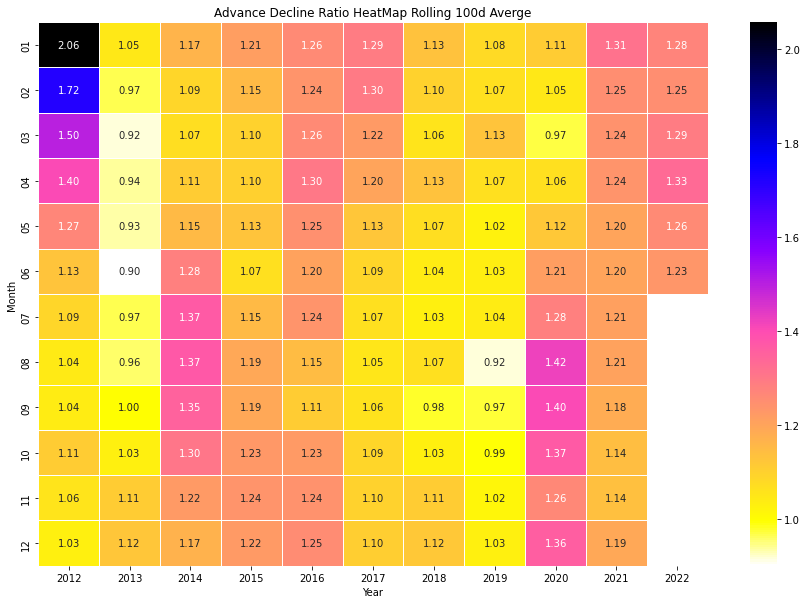

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
sns.heatmap(x, annot = True, fmt = '.2f' ,cmap = 'gnuplot2_r' , linewidth = 1)
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Advance Decline Ratio HeatMap Rolling 100d Averge')